<a href="https://colab.research.google.com/github/Bensmail-anis/Mathematical-Foundations-of-Neural-Networks-with-Micrograd/blob/main/Notebooks/MLP_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session Objective:
In this part of the session, we will start by understanding and utilizing the Neuron,Layer,MLP classes to create a simple neural network from scratch. The primary goal is to grasp how neurons compute outputs through weighted inputs, biases, and activation functions.

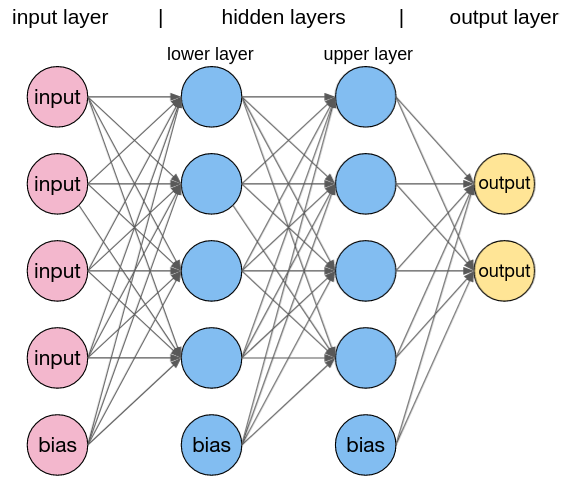

## Building a neuron :

A **neuron** is a fundamental building block of a neural network. Its role is to process incoming information (inputs) and produce an output, which can be passed to other neurons. To capture this behavior in code, we need to define several key elements:

### **1\. Weights and Biases**

A neuron must learn how much importance to give to each input. This is where **weights** come in — they scale the inputs before combining them. Additionally, a **bias** allows the neuron to shift the output, providing more flexibility in decision boundaries.

In our code, we define:

*   A list of weights (self.w) initialized randomly for each input.
    
*   A single bias (self.b), also randomly initialized.These random initializations give the neuron a starting point for learning.

In [ ]:
self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
self.b = Value(random.uniform(-1,1))

### **2\. Activation Function**

After calculating the weighted sum of the inputs plus the bias, the neuron applies an **activation function** to introduce non-linearity. This is essential for modeling complex relationships. In our case, we use the **hyperbolic tangent (tanh)** function, which outputs values between -1 and 1.

The core operation of the neuron becomes:

Output=tanh(w⋅x+b)

In [ ]:
act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
out = act.tanh()


### **3\. Forward Pass**
    
When we "call" the neuron with input data, it computes the weighted sum, adds the bias, and applies the activation function. This is captured in the \_\_call\_\_ method of the class.

In [ ]:
def __call__(self, x):
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out


### **4\. Parameters for Training**

To update the neuron during training, we need access to its parameters (weights and bias). The parameters() method provides this list so they can be adjusted through optimization.

In [ ]:
def parameters(self):
    return self.w + [self.b]


Lets redefine the value class we built in the previous notebook before testing the new classes

In [58]:
import math
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

we define the neuron class now

In [59]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]
# Instantiate a Neuron with 3 inputs
neuron = Neuron(3)

# Define sample inputs
inputs = [Value(0.5), Value(-0.2), Value(0.8)]

# Perform a forward pass
output = neuron(inputs)

print("Neuron Output:", output)
print("Neuron Parameters:", neuron.parameters())


Neuron Output: Value(data=0.144233590185549)
Neuron Parameters: [Value(data=-0.8085691270211424), Value(data=-0.7639603624867994), Value(data=-0.06804985014905451), Value(data=0.45117881370776725)]


## **Building a Layer**

To move beyond a single neuron, we need to organize multiple neurons into a **layer**. This is essential for capturing more complex patterns in the input data.

### **1\. Defining a Layer**

A layer contains multiple neurons, each receiving the same input but producing a different output based on their unique weights and biases. In our code, the layer is represented by a list of Neuron objects.

In [ ]:
self.neurons = [Neuron(nin) for _ in range(nout)]


Here, nin is the number of inputs to each neuron, and nout is the number of neurons in the layer. By creating this list, we can efficiently organize and process computations for all neurons at once.

### **2\. Forward Pass Through the Layer**

When the layer receives input, each neuron processes it independently, and the outputs are combined to form the layer's final output.

If there's only one neuron in the layer, the output is returned directly. Otherwise, a list of outputs is returned. This ensures the layer remains versatile for different architectures.

In [ ]:
def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs


In [60]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


## **Building a Multi-Layer Perceptron (MLP)**

A **Multi-Layer Perceptron (MLP)** is a complete neural network composed of multiple layers of neurons. It serves as a fundamental architecture for many machine learning tasks. By stacking layers, the MLP can model complex relationships between inputs and outputs.

### **1\. Defining the MLP Structure**

An MLP consists of an input layer, hidden layers, and an output layer. In our code, the architecture is defined by specifying the number of neurons in each layer.

Here:

*   nin is the number of input features.
    
*   nouts is a list specifying the number of neurons in each subsequent layer.
    
*   sz combines the input size and the layer sizes to iterate through and create the required Layer instances.

to compute the output, the input is passed sequentially through each layer, transforming it step by step.

In [61]:
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In this example, we are passing an input vector x = [2.0, 3.0, -1.0] through an MLP with 3 input features, 4 neurons in two hidden layers, and 1 output neuron. The model performs a forward pass, and the final output is a Value object with the result -0.6959712731074769.

In [62]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6959712731074769)

again , **let us implement the following neural network architecture using all the classes we defined**
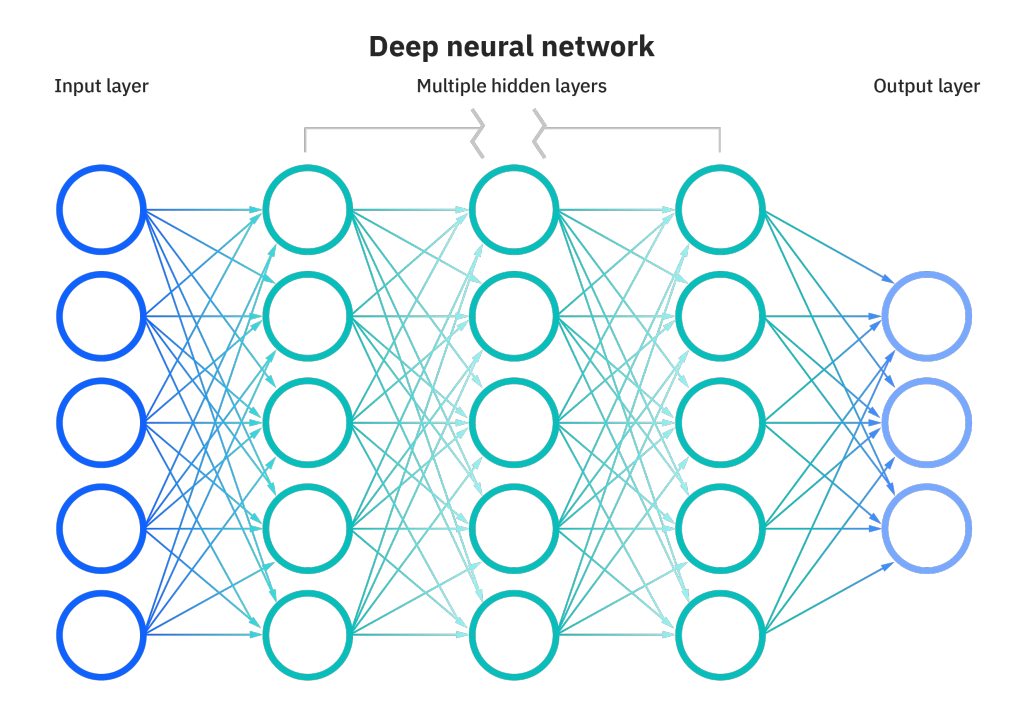

In [64]:
x = [2.0, 3.0, -1.0, 5.0, 8.0]
n = MLP(5, [5, 5, 3])
n(x)

[Value(data=0.7195271949280803),
 Value(data=-0.7409695331748081),
 Value(data=-0.13110491539957964)]

In [72]:
inputs = [
  [8.0, 2.0, 3.0, -1.0,2.0],
  [4.6, 3.0, -1.0, 0.5 , 5.5],
  [3.3 ,0.5, 2.3, 1.0, 1.0],
  [1.0, 1.0, -1.0 , -1.0 , 0.2],
]

num_samples = 4
num_classes = 3

# Generate random one-hot encoded actuals
actuals = []
for _ in range(num_samples):
    one_hot = [0] * num_classes
    one_hot[random.randint(0, num_classes - 1)] = 1
    actuals.append([Value(data=value) for value in one_hot])


preds = [n(x) for x in inputs]
preds

[[Value(data=-0.22000473149920094),
  Value(data=-0.861613230806428),
  Value(data=0.9023901319862102)],
 [Value(data=0.42874738595306144),
  Value(data=-0.7628166776597132),
  Value(data=0.7008388445083849)],
 [Value(data=-0.5084413848192766),
  Value(data=-0.0979036473119953),
  Value(data=0.9357121265317438)],
 [Value(data=-0.07301666531085872),
  Value(data=-0.14864478199076253),
  Value(data=0.9133348265779685)]]

In [73]:
n.parameters()

[Value(data=-0.0386169439078512),
 Value(data=0.7840172535300542),
 Value(data=-0.9192392921885744),
 Value(data=-0.5436231015412536),
 Value(data=-0.08863297573916196),
 Value(data=0.38557910700358566),
 Value(data=-0.6008035592490812),
 Value(data=0.9235871800805142),
 Value(data=0.8939560155080966),
 Value(data=-0.8476699909618672),
 Value(data=0.44417566197910263),
 Value(data=-0.7977009725722364),
 Value(data=0.6956544896313377),
 Value(data=0.5627853088019237),
 Value(data=0.45482241201969464),
 Value(data=-0.6711576155296406),
 Value(data=-0.0925987760326763),
 Value(data=0.2618702203731891),
 Value(data=0.8508615575736642),
 Value(data=0.8442646343121651),
 Value(data=0.6863339070736609),
 Value(data=-0.5719829557555871),
 Value(data=-0.5642762243989965),
 Value(data=-0.5723216329928518),
 Value(data=-0.18926106486910688),
 Value(data=0.11226911894666314),
 Value(data=0.0013346646291076958),
 Value(data=-0.013482558234543474),
 Value(data=-0.6377591625150698),
 Value(data=0.819

In [74]:
len(n.parameters())

78

In [96]:
actuals

[[Value(data=0), Value(data=1), Value(data=0)],
 [Value(data=0), Value(data=1), Value(data=0)],
 [Value(data=0), Value(data=1), Value(data=0)],
 [Value(data=1), Value(data=0), Value(data=0)]]

**We implement the MSE loss** , look to the loss for each value

In [76]:
[(actual - pred) ** 2 for actual_list, pred_list in zip(actuals, preds) for actual, pred in zip(actual_list, pred_list)]

[Value(data=0.0484020818820355),
 Value(data=3.4656038211135467),
 Value(data=0.8143079503060899),
 Value(data=0.18382432096158344),
 Value(data=3.107522639035229),
 Value(data=0.49117508597184806),
 Value(data=0.2585126417969437),
 Value(data=1.205392418780982),
 Value(data=0.8755571837385582),
 Value(data=1.1513647640348357),
 Value(data=0.02209527121308132),
 Value(data=0.8341805054402078)]

In [77]:
loss = sum(
    (actual - pred) ** 2
    for actual_list, pred_list in zip(actuals, preds)
    for actual, pred in zip(actual_list, pred_list)
)


In [78]:
loss

Value(data=12.45793868427494)

To update the wights , we use magic :

In [79]:
n.layers[0].neurons[0].w[0].grad

0.0

In [80]:
loss.backward()

In [82]:
n.layers[0].neurons[0].w[0]

Value(data=-0.0386169439078512)

In [83]:
n.layers[0].neurons[0].w[0].grad # it was initialised at 0  , and then calculated after the backward pass

-1.2274186945783703

increasing this first weight , it means loss will go down since the grad is negative after applying backward

**Remember , our goal is to minimize always the loss**

In [101]:
n = MLP(5, [5, 5, 3])

In [103]:
for k in range(20):

  # forward pass
  preds = [n(x) for x in inputs]
  loss = sum((actual - pred) ** 2 for actual_list, pred_list in zip(actuals, preds) for actual, pred in zip(actual_list, pred_list))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad # optimizer , it updates the weights , remember that if the grad is negative , we have to increase the weight by a learning rate defined here as 0.01 , if the grad is positive , the weight must be decreased

  print(k, loss.data)

0 1.430694074357801
1 0.9883793878559136
2 0.6792551889184533
3 0.48239349233334194
4 0.36430511821246825
5 0.2951302211540015
6 0.2541973282885845
7 0.22896375103945638
8 0.21233104669087005
9 0.2004239539573105
10 0.19116354639119298
11 0.18344190538105332
12 0.17666789047376238
13 0.1705232976975735
14 0.16483364116945298
15 0.15950014852074554
16 0.15446410350514245
17 0.1496881806217076
18 0.145146674025229
19 0.14082037192454006


**The neural network is improving its predictions**

In [104]:
actuals

[[Value(data=0), Value(data=1), Value(data=0)],
 [Value(data=0), Value(data=1), Value(data=0)],
 [Value(data=0), Value(data=1), Value(data=0)],
 [Value(data=1), Value(data=0), Value(data=0)]]

In [105]:
preds

[[Value(data=-0.036180876851131735),
  Value(data=0.8946624160846981),
  Value(data=-0.009108563694544523)],
 [Value(data=0.12564718679266385),
  Value(data=0.9220593355949914),
  Value(data=0.16356033769712783)],
 [Value(data=-0.03438267488643625),
  Value(data=0.8941551334483653),
  Value(data=-0.009307058562685322)],
 [Value(data=0.8172051948097981),
  Value(data=0.02436171052428336),
  Value(data=-0.1823157633935349)]]